## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [29]:
mylist= os.listdir('C:/Voice_all/')

In [30]:
type(mylist)

list

In [31]:
print(mylist[800])

03-01-05-02-01-02-09.wav


In [32]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [34]:
data, sampling_rate = librosa.load('C:/Voice_all/03-01-05-02-01-02-09.wav')

Populating the interactive namespace from numpy and matplotlib


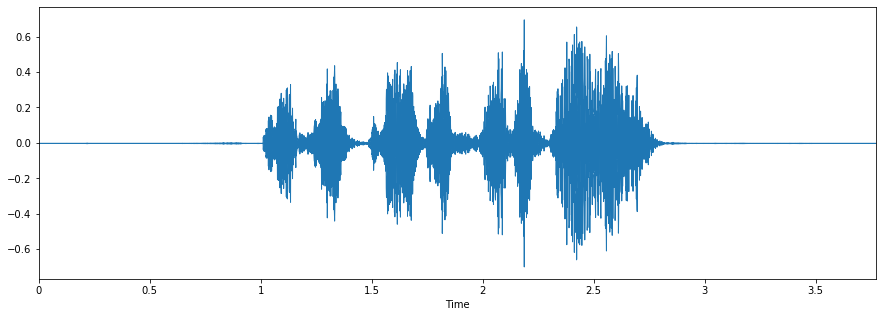

In [35]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [37]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [38]:
labels = pd.DataFrame(feeling_list)

In [39]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [40]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('C:/Voice_all/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [41]:
df[:5]

,feature
0,"[-70.2677641610773, -70.2677641610773, -70.267..."
1,"[-65.70765240065282, -65.70765240065282, -63.1..."
2,"[-65.4824988827423, -65.4824988827423, -65.482..."
3,"[-64.52844910346735, -64.52844910346735, -64.5..."
4,"[-62.36431052745468, -59.93472513811134, -61.8..."


In [42]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [43]:
newdf = pd.concat([df3,labels], axis=1)

In [44]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [45]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.082741,-60.234652,male_calm
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.144064,-48.705645,female_calm
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.323644,-40.710780,male_calm
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.610100,-44.698259,female_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.383777,-43.965398,male_calm


In [46]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
146,-55.432984,-56.202228,-57.184010,-57.505661,-56.593266,-55.006390,-54.756210,-56.295744,-58.478039,-57.118607,...,-24.977090,-25.839029,-24.558172,-24.293968,-23.481319,-22.684277,-21.958473,-20.250398,-18.629301,male_calm
583,-50.545312,-48.991972,-48.865521,-49.207718,-50.144840,-48.545571,-49.289383,-50.947019,-50.168514,-50.172467,...,-44.672711,-49.168897,-48.626179,-49.492818,-49.116773,-48.921223,-46.197038,-45.821223,-48.995852,female_angry
161,-66.471029,-66.464810,-66.471029,-66.471029,-66.471029,-66.471029,-66.471029,-66.471029,-66.471029,-66.471029,...,-64.386411,-62.351795,-64.222398,-66.152031,-63.642780,-63.769040,-66.471029,-66.471029,-65.012717,female_calm
201,-48.981466,-47.696597,-47.206740,-48.770675,-46.975942,-46.064501,-45.844486,-45.215074,-46.174046,-46.502808,...,-48.041735,-47.311513,-48.412880,-48.155535,-44.662251,-45.211056,-47.680673,-48.981466,-48.981466,female_happy
608,-66.323343,-66.323343,-66.323343,-66.323343,-66.323343,-66.323343,-66.323343,-66.323343,-66.323343,-66.323343,...,-49.012368,-49.231145,-47.134626,-46.901940,-45.832007,-45.729526,-46.371648,-47.507066,-48.348944,male_angry
644,-43.827917,-43.578338,-43.234601,-43.572731,-43.827917,-43.827917,-43.827917,-43.558638,-43.596133,-43.827917,...,-15.646369,-17.103772,-18.060084,-18.300959,-18.904725,-19.821105,-20.766101,-22.422723,-21.765500,male_angry
802,-53.681973,-53.438813,-53.929762,-54.572111,-55.788444,-53.071579,-52.550545,-51.727692,-52.331120,-55.029013,...,-49.898227,-48.781587,-49.259988,-48.016841,-49.829879,-50.776049,-49.930760,-52.789976,-55.869079,male_fearful
612,-53.700269,-53.832939,-55.695274,-55.929055,-54.200609,-53.187270,-53.727313,-55.705841,-56.291958,-55.521416,...,-53.805988,-54.251546,-54.206439,-53.196967,-54.226904,-55.663953,-53.149880,-51.462828,-52.426772,male_angry
562,-29.514870,-31.776139,-36.120101,-35.954008,-35.894216,-35.951364,-34.607066,-35.883417,-36.135357,-37.427406,...,-45.210504,-46.084817,-45.995474,-46.169773,-46.866463,-47.589461,-48.592283,-48.842870,-50.810683,male_sad
98,-46.148892,-45.965900,-46.465774,-50.426823,-50.016897,-49.716412,-49.669726,-49.205231,-50.857016,-52.708616,...,-24.640589,-25.523332,-25.462610,-25.559839,-25.279617,-25.475659,-26.474084,-24.673720,-23.300059,male_calm


In [47]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [48]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [49]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
560,-56.741266,-57.096956,-60.335412,-62.451952,-59.003335,-60.339123,-63.469751,-66.836010,-64.909165,-64.727420,...,-49.501543,-55.001044,-56.785555,-51.061866,-49.443464,-54.635694,-55.019453,-56.437112,-55.552043,male_sad
387,-65.616624,-65.616624,-65.616624,-65.629987,-64.431612,-64.589771,-65.616624,-65.616624,-65.616624,-65.616624,...,-59.438908,-62.978231,-60.258270,-57.235445,-55.851677,-58.888949,-59.853692,-61.910080,-61.882730,female_sad
475,-77.300767,-77.871972,-78.612838,-79.002560,-79.325658,-79.323007,-79.323007,-79.323007,-79.323007,-79.323007,...,-63.696232,-67.464793,-65.756060,-66.345690,-66.215256,-60.145253,-62.800592,-62.715150,-62.603528,female_sad
539,-52.150201,-52.054038,-52.210037,-52.210308,-52.117225,-52.057665,-52.019825,-52.019825,-52.019825,-52.019825,...,-47.654898,-47.466899,-47.735275,-48.166131,-47.081075,-46.531241,-45.782631,-46.428393,-46.711735,female_sad
280,-50.683447,-49.582845,-49.573145,-49.530697,-51.778389,-49.248276,-49.240766,-49.972067,-51.259530,-50.161117,...,-50.108314,-50.828198,-51.525122,-50.562866,-49.983553,-52.057093,-50.964304,-50.562960,-51.980808,male_happy
11,-64.663055,-64.448593,-65.173871,-65.662805,-65.662805,-65.662805,-65.662805,-65.662805,-65.662805,-65.662805,...,-35.964399,-38.152092,-39.424238,-39.348848,-39.895474,-39.905080,-42.550736,-43.243879,-39.797571,female_calm
511,-45.182998,-47.211669,-50.592894,-53.360218,-51.247242,-50.312643,-51.028291,-51.513125,-50.413727,-48.315339,...,-49.372282,-47.701173,-50.583976,-51.380535,-51.403674,-51.627796,-48.571527,-48.987322,-47.773933,female_sad
196,-57.895241,-56.911636,-57.946421,-58.111761,-55.472795,-56.331500,-57.309017,-60.092864,-59.959078,-58.216662,...,-33.844675,-33.636118,-33.725746,-34.900446,-38.407901,-38.195317,-38.506610,-38.173440,-34.352565,male_happy
393,-52.144882,-53.959018,-55.145461,-53.612339,-52.147070,-49.463857,-49.172999,-52.111884,-53.611675,-50.524048,...,-50.998890,-52.317006,-51.349279,-51.088707,-51.130629,-50.069041,-50.267326,-51.520944,-52.932136,female_sad
231,-56.143983,-56.115295,-56.115295,-56.115295,-56.115295,-56.115295,-56.115295,-56.115295,-56.115295,-56.115295,...,-49.816833,-53.152288,-50.878348,-51.290188,-51.298487,-53.192987,-52.801656,-50.226913,-51.494558,female_happy


In [50]:
trainfeatures = train.iloc[:, :-1]

In [51]:
trainlabel = train.iloc[:, -1:]

In [52]:
testfeatures = test.iloc[:, :-1]

In [53]:
testlabel = test.iloc[:, -1:]

In [54]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\Asus\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [56]:
X_train.shape

(766, 216)

## Changing dimension for CNN model

In [57]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [104]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [105]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_9 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_10 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 27, 128)           82048     
__________

In [106]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [107]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Train on 766 samples, validate on 194 samples
Epoch 1/700
766/766 [==============================] - 4s 5ms/step - loss: 2.8134 - acc: 0.1057 - val_loss: 2.3677 - val_acc: 0.1031
Epoch 2/700
766/766 [==============================] - 3s 4ms/step - loss: 2.3431 - acc: 0.0979 - val_loss: 2.3181 - val_acc: 0.1443
Epoch 3/700
766/766 [==============================] - 3s 4ms/step - loss: 2.2976 - acc: 0.1292 - val_loss: 2.3019 - val_acc: 0.0825
Epoch 4/700
766/766 [==============================] - 4s 5ms/step - loss: 2.2656 - acc: 0.1384 - val_loss: 2.2683 - val_acc: 0.1443
Epoch 5/700
766/766 [==============================] - 4s 5ms/step - loss: 2.2425 - acc: 0.1580 - val_loss: 2.2468 - val_acc: 0.2268
Epoch 6/700
766/766 [==============================] - 3s 4ms/step - loss: 2.2251 - acc: 0.1645 - val_loss: 2.2326 - val_acc: 0.2113: 1s - loss: 2.2268 - acc: 0.1 - ETA: 1s - loss: 2.224
Epoch 7/700
766/766 [==============================] - 4s 6ms/step - loss: 2.2004 - acc: 0.2128 - val_

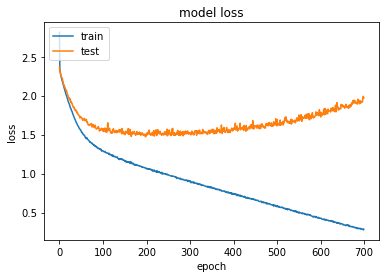

In [108]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [111]:
model_name = 'Emotion_Voice_Detection_Model2.h5'
save_dir = os.path.join(os.getcwd(), 'C:/my_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:/my_models\Emotion_Voice_Detection_Model2.h5 


In [112]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [140]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/my_models/Emotion_Voice_Detection_Model2.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 46.91%


#pred

In [141]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

194/194 [==============================] - 0s 2ms/step


In [142]:
preds

array([[1.2271674e-05, 1.1830255e-07, 1.7130513e-07, ..., 4.1565467e-02,
        2.7543104e-01, 6.9329306e-03],
       [2.4957684e-05, 8.8581979e-01, 1.6943505e-02, ..., 2.8401459e-02,
        4.2887989e-02, 9.9868262e-03],
       [1.4472539e-07, 7.0065513e-17, 1.6014674e-09, ..., 1.1355961e-04,
        7.6384698e-05, 3.0686543e-08],
       ...,
       [3.5623757e-03, 8.1690578e-06, 2.0400823e-06, ..., 1.1689301e-01,
        2.0518999e-01, 1.4639289e-04],
       [1.0254214e-01, 5.1083755e-01, 1.4137062e-02, ..., 1.3738591e-02,
        3.5497991e-04, 8.0039687e-02],
       [6.2653367e-06, 2.2164797e-06, 1.2635531e-06, ..., 9.0816206e-01,
        1.7277834e-03, 1.9030472e-02]], dtype=float32)

In [143]:
preds1=preds.argmax(axis=1)

In [144]:
preds1

array([5, 1, 5, 9, 6, 9, 5, 2, 4, 0, 0, 5, 2, 3, 9, 1, 7, 0, 6, 6, 2, 9,
       8, 6, 9, 7, 0, 6, 6, 1, 1, 3, 8, 1, 2, 5, 7, 4, 6, 0, 0, 2, 0, 2,
       6, 3, 4, 6, 9, 2, 8, 7, 1, 2, 4, 6, 7, 3, 7, 8, 7, 2, 0, 5, 3, 5,
       2, 2, 9, 7, 7, 2, 8, 4, 4, 4, 8, 9, 2, 9, 7, 6, 9, 5, 5, 4, 7, 0,
       3, 8, 5, 2, 2, 1, 4, 4, 6, 8, 1, 2, 3, 5, 7, 8, 3, 0, 7, 2, 5, 8,
       6, 4, 6, 8, 9, 4, 1, 9, 9, 4, 6, 0, 7, 2, 7, 8, 2, 8, 0, 7, 2, 7,
       2, 6, 4, 1, 3, 9, 3, 6, 7, 8, 1, 8, 5, 7, 9, 9, 9, 7, 3, 6, 5, 3,
       5, 4, 0, 0, 3, 6, 2, 6, 2, 6, 8, 1, 8, 0, 7, 2, 5, 8, 2, 9, 4, 5,
       7, 8, 3, 6, 2, 6, 9, 9, 9, 2, 1, 6, 7, 1, 4, 5, 1, 7], dtype=int64)

In [145]:
abc = preds1.astype(int).flatten()

In [146]:
predictions = (lb.inverse_transform((abc)))

In [147]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,female_calm
2,male_angry
3,male_sad
4,male_calm
5,male_sad
6,male_angry
7,female_fearful
8,female_sad
9,female_angry


In [148]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [149]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,female_calm
2,male_angry
3,male_calm
4,male_sad
5,female_sad
6,male_fearful
7,female_sad
8,female_sad
9,female_angry


#### test output

In [150]:
data, sampling_rate = librosa.load('C:/test_audio/output10.wav')

Populating the interactive namespace from numpy and matplotlib


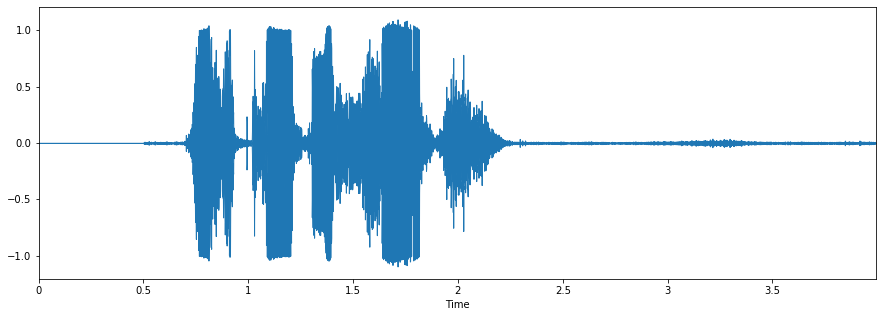

In [151]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [159]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('C:/test_audio/output2.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [160]:
livedf2= pd.DataFrame(data=livedf2)

In [161]:
livedf2 = livedf2.stack().to_frame().T

In [162]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-70.152745,-69.913691,-67.810702,-68.664977,-71.470452,-71.470452,-71.470452,-71.470452,-71.470452,-71.470452,...,-45.462678,-43.779465,-43.768887,-44.085496,-43.97565,-44.347019,-44.098364,-46.298862,-47.547014,-46.484299


In [163]:
twodim= np.expand_dims(livedf2, axis=2)

In [164]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 29ms/step


In [165]:
livepreds

array([[2.5578358e-03, 8.4999132e-01, 5.5450872e-02, 8.5636294e-03,
        7.6262474e-02, 1.1075696e-09, 1.1046615e-03, 7.4910087e-05,
        1.8627905e-04, 5.8080726e-03]], dtype=float32)

In [166]:
livepreds1=livepreds.argmax(axis=1)

In [167]:
liveabc = livepreds1.astype(int).flatten()

In [168]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_calm'], dtype=object)